In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math
import sklearn.metrics as skm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import RepeatVector, TimeDistributed

import sqlite3 as sql
import seaborn as sns
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime

In [6]:
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

In [7]:
def split_dataset(data, test_size=60, predict_window=7):
    '''
    '''
    train, test = data[1:-test_size], data[-test_size:-(predict_window-1)]
    return train, test


In [8]:
def sliding_window(train, sw_width=7, n_out=1, in_start=0):
    '''
    cut data into window
    '''
    X, y = [], []
    
    for _ in range(len(train)):
        in_end = in_start + sw_width
        out_end = in_end + n_out
        if out_end < len(train):
            X.append(train[in_start:in_end, :])
            y.append(train[in_end:out_end, 0])
        in_start += 1
        
    return np.array(X), np.array(y)

In [9]:
def lstm_model(train, sw_width, in_start=0, verbose_set=0, epochs_num=20, batch_size_set=4, layer1_unit=200, layer2_unit=100, layer3_unit=50):

    
    train_x, train_y = sliding_window(train, sw_width, n_out=1, in_start=in_start)
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    
    model = Sequential()
    model.add(LSTM(layer1_unit, activation='relu', 
                   input_shape=(n_timesteps, n_features)))
    model.add(Dense(layer2_unit, activation='relu'))
    model.add(Dense(n_outputs))
    
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    history = model.fit(train_x, train_y,
              epochs=epochs_num, batch_size=batch_size_set, verbose=verbose_set)
    return model, history

In [10]:
def evaluate_forecasts(actual, predicted):

    mse = skm.mean_squared_error(actual, predicted)
    rmse = math.sqrt(mse)
    error = rmse / len(actual)
   
    print('average RMSE:' , error)
    return error


In [11]:
def summarize_scores(name, error):
    print('%s: [%.3f] \n' % (name, error))


In [12]:
def forecast(model, pred_seq, sw_width):

    data = np.array(pred_seq)
    input_x = data[-sw_width:, :]
    input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1])) #reshape to[1, n_input, n]
    
    yhat = model.predict(input_x, verbose=0) # 
    yhat = yhat[0] # 
    return yhat

In [13]:
def evaluate_model(model, train, test, sd_width):

    history_fore = train
    test_x, test_y = sliding_window(test, sd_width, in_start=0)
    predictions = list() # 
    for i in range(len(test_x)):
        yhat_sequence = forecast(model, history_fore, sd_width) # 
        predictions.append(yhat_sequence) # 
        history_fore = np.append(history_fore, [test[i]], axis=0) # 

    
    predictions = np.array(predictions) # 
#     print(predictions)
    error = evaluate_forecasts(test_y[:, 0], predictions[:, 0])
    return error, test_y[:, 0], predictions[:, 0]

In [14]:
def model_plot(actual, predict, name):

    plt.figure(figsize=(8,6), dpi=150)
    plt.plot(actual, marker='o', label="actual")
    plt.plot(predict, marker='x', label="predicated")
    plt.grid(linestyle='--', alpha=0.5)
    plt.ylabel(r'$Price$', size=15)
    plt.title('LSTM Bitcoin Predication Result',  size=18)
    plt.legend()
    plt.show()

verifying:  3 50 3 50 25
searching models no: 1
searched: 0.0
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                11800     
_________________________________________________________________
dense (Dense)                (None, 25)                1275      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 13,101
Trainable params: 13,101
Non-trainable params: 0
_________________________________________________________________
None
average RMSE: 79.11585277588367
search done
final hyer parameters:  (3, 50, 3, 50, 25)
LSTM: [79.116] 



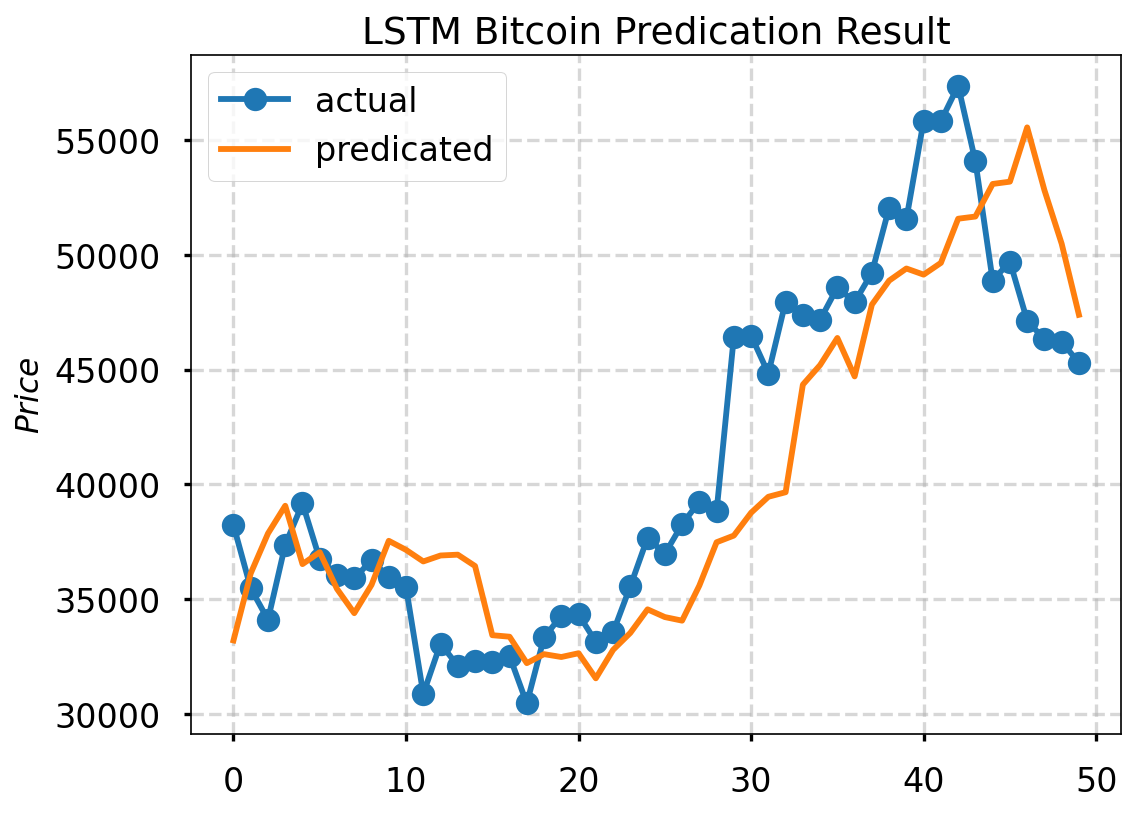

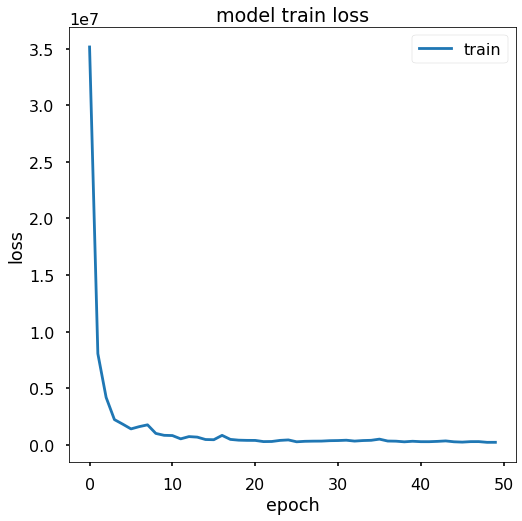

In [15]:
if __name__ == '__main__':
    
#     dataset = pd.read_csv('household_power_consumption_days.csv', header=0, 
#                    infer_datetime_format=True, engine='c',
#                    parse_dates=['datetime'], index_col=['datetime'])
    con = sql.connect("./data/paperdb.db")
    SQL_BTC_USD_TRAIN = """
        select 
        btc.date
        ,btc."close" as btc_price
        ,eu."close" as euro_price
        ,gu."close" as gold_price
        ,uc."close" as cny_price
        ,s2."close" as sp_price
        ,s."close" as sh_price
        ,bi.search_cnt 
        ,gt.bitcoin 
        from BTC_USD btc
        left outer join EUR_USD eu on btc.date = eu.date 
        left outer join GOLD_USD gu on btc.date = gu.date 
        left outer join USD_CNH uc on btc.date = uc.date 
        left outer join SP500 s2 on btc.date = s2.date 
        left outer join SHSTOCK s on btc.date = s.date 
        left outer join BAIDU_INDEX bi on btc.date = bi.date 
        left outer join GOOGLE_TRENDS gt  on btc.date = gt.Column1 
        where btc.date>='2019-01-04'  order by btc.date asc
    """
    btc_usd = pd.read_sql(SQL_BTC_USD_TRAIN, con)
    btc_usd = btc_usd.fillna(method='ffill')
    btc_usd.Timestamp = pd.to_datetime(btc_usd.date)
    # Resampling to daily frequency
    btc_usd.index = btc_usd.Timestamp
    del btc_usd['date']
    dataset = btc_usd.values.astype('float64')

    
    name = 'LSTM'
    verbose_set=0
    in_start=0
    
#     sw_widths = [3,4]
#     epochs_nums= [50,75]
#     batch_size_sets=[3,4,5]
    
#     layer1_units=[50,100]
#     layer2_units=[25,50]
    sw_widths = [3]
    epochs_nums= [50]
    batch_size_sets=[3]
    
    layer1_units=[50]
    layer2_units=[25]
    
    curr_error = 100000
    best_model = None
    best_hyper = 0
    best_history = None

    params = []
    train, test = split_dataset(dataset)
    
    for sw_width in sw_widths:
        for epochs_num in epochs_nums:
            for batch_size_set in batch_size_sets:
                for layer1_unit in layer1_units:
                    for layer2_unit in layer2_units:
                        params.append((sw_width,epochs_num,batch_size_set,layer1_unit, layer2_unit))
    
    search_cnt = 0
    for param in params:
        sw_width,epochs_num,batch_size_set,layer1_unit, layer2_unit = param
        print("verifying: ",sw_width,epochs_num,batch_size_set,layer1_unit, layer2_unit )
        print("searching models no:", search_cnt+1)
        print("searched:", (search_cnt) / len(params))

#     t_train, validation = split_dataset(train, test_size=15)
        model, history = lstm_model(train, sw_width, in_start=in_start, verbose_set=verbose_set, epochs_num=epochs_num,
                                batch_size_set=batch_size_set,layer1_unit=layer1_unit, layer2_unit=layer2_unit, layer3_unit=50)
        error, actual, predict = evaluate_model(model, train, test, sw_width)

        if error < curr_error:
            curr_error = error
            best_model = model
            best_history = history
            best_actual = actual
            best_predict = predict
            best_hyper = search_cnt
        search_cnt = search_cnt + 1
    print("search done")
    print("final hyer parameters: ", params[best_hyper])

    
    summarize_scores(name, curr_error)
    model_plot(best_actual, best_predict, name)
    plt.figure(figsize=(8,8))
    plt.plot(best_history.history['loss'])
    plt.title('model train loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','validation'], loc='upper right')
    plt.show()